In [5]:
#!pip install netcdf4

   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB 140.3 kB/s eta 0:00:50
   ---------------------------------------- 0.0/7.0 MB 140.3 kB/s eta 0:00:50
   ---------------------------------------- 0.0/7.0 MB 140.3 kB/s eta 0:00:50
   ---------------------------------------- 0.1/7.0 MB 142.6 kB/s eta 0:00:49
   ---------------------------------------- 0.1/7.0 MB 176.6 kB/s eta 0:00:40
    --------------------------------------- 0.1/7.0 MB 180.8 kB/s eta 0:00:39
    --------------------------------------- 0.1/7


[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the NetCDF file path
nc_file = '2m_temperature_nanjing.nc'

# Try opening the dataset with available engines
try:
    ds = xr.open_dataset(nc_file)
except ValueError:
    print("netcdf4 engine not found. Trying with scipy.")
    ds = xr.open_dataset(nc_file, engine="scipy")  # Use scipy as a fallback

# Check dataset structure
print(ds)

<xarray.Dataset> Size: 6MB
Dimensions:     (valid_time: 8784, latitude: 9, longitude: 9)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 70kB 1996-01-01 ... 1996-12-31T23...
  * latitude    (latitude) float64 72B 33.0 32.75 32.5 32.25 ... 31.5 31.25 31.0
  * longitude   (longitude) float64 72B 117.0 117.2 117.5 ... 118.5 118.8 119.0
    expver      (valid_time) <U4 141kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 3MB ...
    t2m         (valid_time, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-26T00:39 GRIB to CDM+CF via cfgrib-0.9.1...


In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Read the NetCDF file containing temperature data
nc_file = '2m_temperature_nanjing.nc'
ds = xr.open_dataset(nc_file)
ds

<xarray.Dataset> Size: 6MB
Dimensions:     (valid_time: 8784, latitude: 9, longitude: 9)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 70kB 1996-01-01 ... 1996-12-31T23...
  * latitude    (latitude) float64 72B 33.0 32.75 32.5 32.25 ... 31.5 31.25 31.0
  * longitude   (longitude) float64 72B 117.0 117.2 117.5 ... 118.5 118.8 119.0
    expver      (valid_time) <U4 141kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 3MB ...
    t2m         (valid_time, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-26T00:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
# Extract data for Nanjing by finding the closest lat/lon point
# Nanjing coordinates: 32.06°N, 118.79°E
lat_idx = np.argmin(np.abs(ds.latitude.values - 32.06))
lon_idx = np.argmin(np.abs(ds.longitude.values - 118.79))
nanjing_temp = ds.t2m.isel(latitude=lat_idx, longitude=lon_idx)

# Convert xarray DataArray to pandas DataFrame
df = nanjing_temp.to_dataframe().reset_index()
df = df.set_index('valid_time')  # Set the time column as index
df = df[['t2m']]  # Select only the temperature column
df.columns = ['temperature']  # Rename the column for clarity
# Convert temperature from Kelvin to Celsius
df['temperature'] = df['temperature'] - 273.15

In [7]:
# Preprocess the data: normalize using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)


# Function to create sequences for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)


# Create sequences with length 3 for prediction
seq_length = 3  # Use 3 time steps to predict the next one
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
# Use the last 10 days (240 hours) as the test set
train_size = len(X) - 240
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert numpy arrays to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Create DataLoader for batch processing during training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [8]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [9]:
# Initialize the model, loss function, and optimizer
model = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X.unsqueeze(2))
        # Compute loss
        loss = criterion(outputs, batch_y.unsqueeze(1))
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0021
Epoch [2/100], Loss: 0.0011
Epoch [3/100], Loss: 0.0010
Epoch [4/100], Loss: 0.0021
Epoch [5/100], Loss: 0.0030
Epoch [6/100], Loss: 0.0014
Epoch [7/100], Loss: 0.0004
Epoch [8/100], Loss: 0.0009
Epoch [9/100], Loss: 0.0004
Epoch [10/100], Loss: 0.0008
Epoch [11/100], Loss: 0.0013
Epoch [12/100], Loss: 0.0003
Epoch [13/100], Loss: 0.0005
Epoch [14/100], Loss: 0.0006
Epoch [15/100], Loss: 0.0005
Epoch [16/100], Loss: 0.0011
Epoch [17/100], Loss: 0.0001
Epoch [18/100], Loss: 0.0004
Epoch [19/100], Loss: 0.0006
Epoch [20/100], Loss: 0.0006
Epoch [21/100], Loss: 0.0007
Epoch [22/100], Loss: 0.0009
Epoch [23/100], Loss: 0.0018
Epoch [24/100], Loss: 0.0005
Epoch [25/100], Loss: 0.0003
Epoch [26/100], Loss: 0.0005
Epoch [27/100], Loss: 0.0003
Epoch [28/100], Loss: 0.0003
Epoch [29/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0004
Epoch [31/100], Loss: 0.0004
Epoch [32/100], Loss: 0.0004
Epoch [33/100], Loss: 0.0003
Epoch [34/100], Loss: 0.0002
Epoch [35/100], Loss: 0

In [10]:
# Make predictions
model.eval()
with torch.no_grad():
    train_predict = model(X_train.unsqueeze(2)).squeeze().numpy()
    test_predict = model(X_test.unsqueeze(2)).squeeze().numpy()

### Training and Testing Data Plot for LSTM

In [17]:
# If using PyTorch, you can use model's forward method to generate predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(last_sequence)  # Forward pass to get the prediction


AttributeError: 'LSTM' object has no attribute 'predict'

## Temperature Time Series Plot:
### This visualization helps to understand the changes in temperature over time, and how the dataset behaves over the entire period.

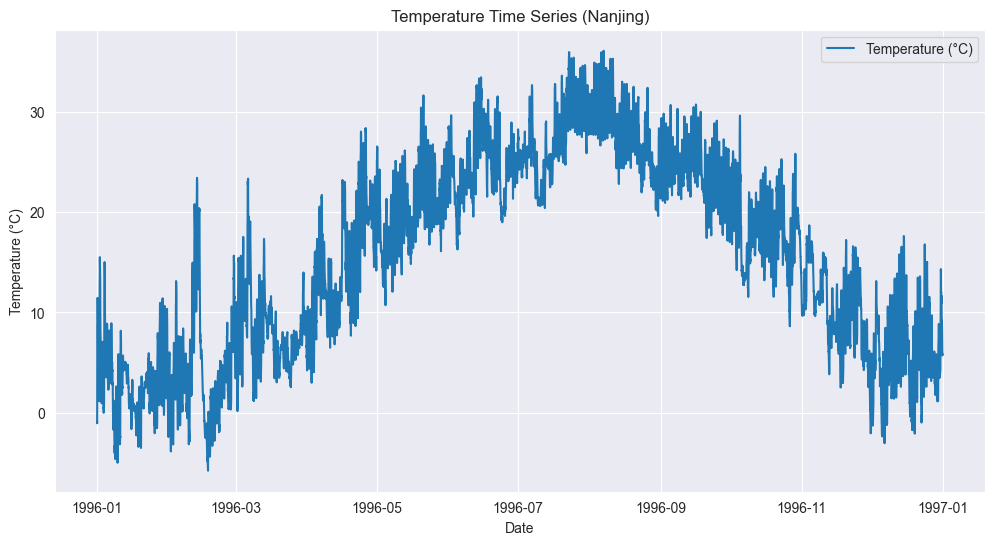

In [13]:
import matplotlib.pyplot as plt

# Plotting the temperature data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temperature'], label='Temperature (°C)')
plt.title('Temperature Time Series (Nanjing)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

## Training and Testing Plots Analysis

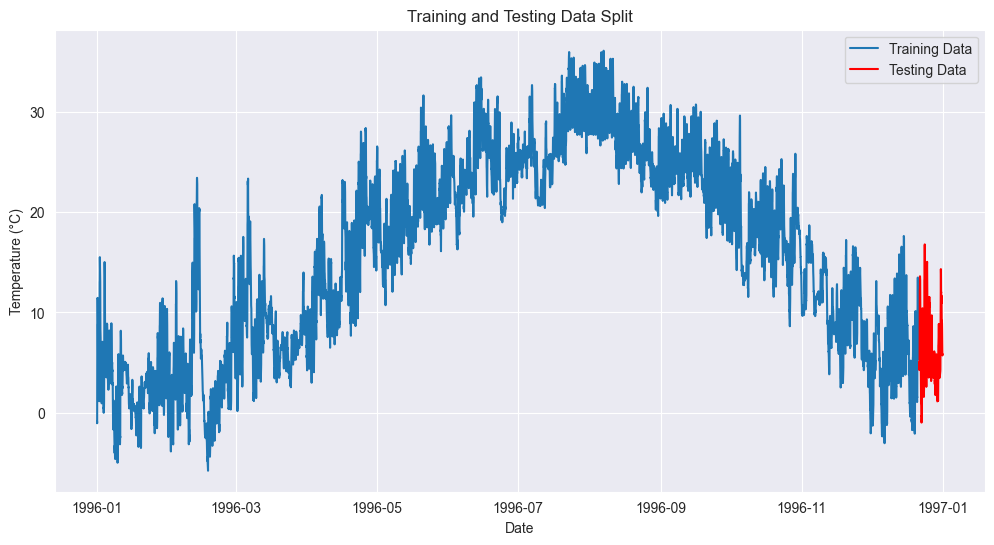

In [14]:
# Plot training and testing data
plt.figure(figsize=(12, 6))
plt.plot(df.index[:train_size], df['temperature'][:train_size], label='Training Data')
plt.plot(df.index[train_size:], df['temperature'][train_size:], label='Testing Data', color='red')
plt.title('Training and Testing Data Split')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

## Scaled Temperature Data:
#### Display the effect of normalization, showing how the temperature values are scaled into the range [0, 1]

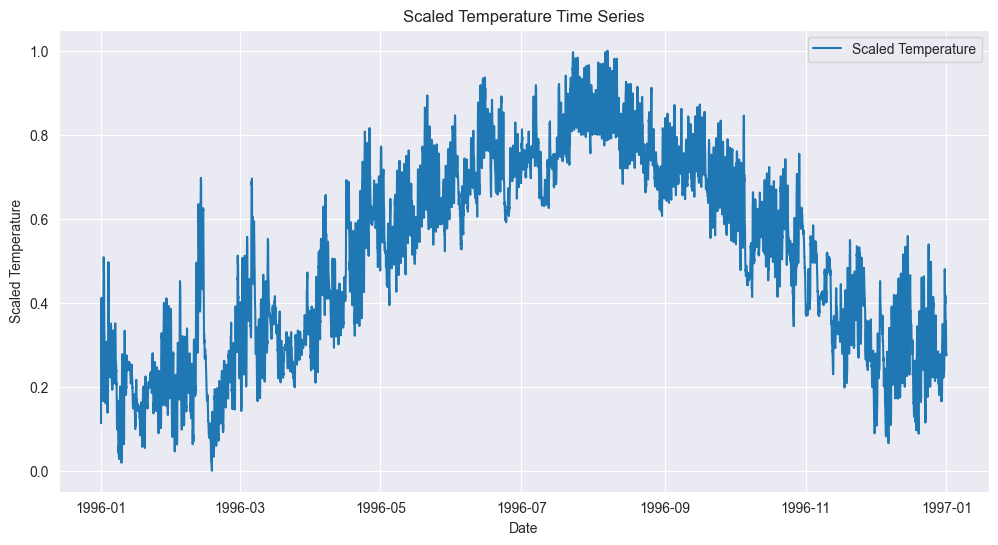

In [15]:
# Plot the scaled temperature data
scaled_temp_df = pd.DataFrame(scaled_data, columns=['scaled_temperature'], index=df.index)
plt.figure(figsize=(12, 6))
plt.plot(scaled_temp_df.index, scaled_temp_df['scaled_temperature'], label='Scaled Temperature')
plt.title('Scaled Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Scaled Temperature')
plt.legend()
plt.grid(True)
plt.show()

## Model Performance (Future Predictions):
#### Once the model is trained and predictions are made, visualize the predicted vs. actual temperature for both the training and testing periods

### Evaluation Matrix

Train RMSE: 1.00
Test RMSE: 1.24


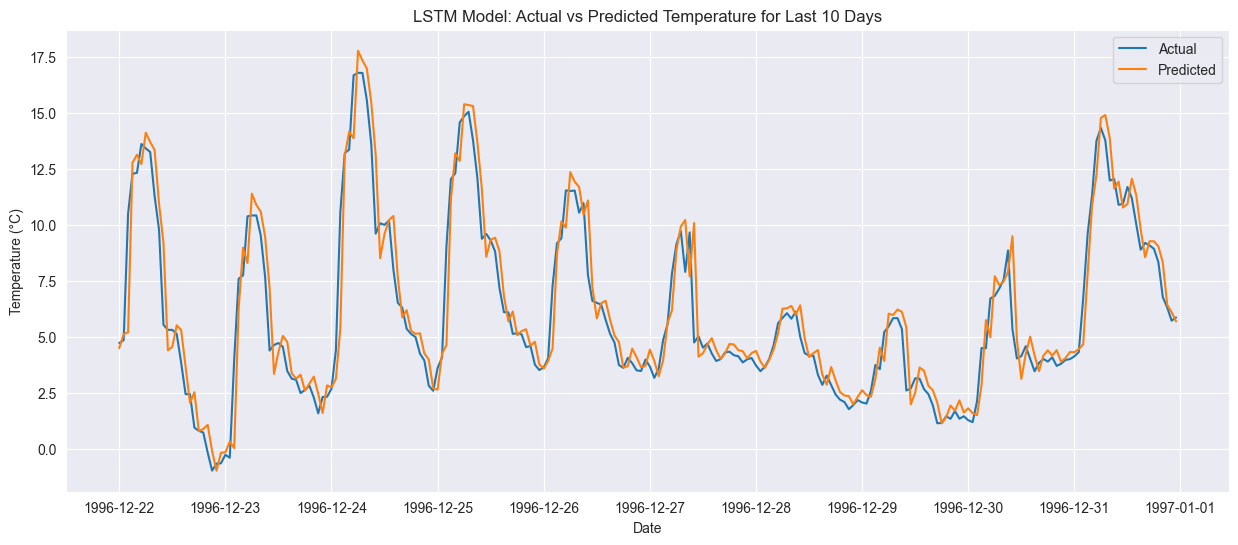

In [12]:
# Calculate Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(np.mean((train_predict - y_train) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(df.index[-240:], y_test, label='Actual')
plt.plot(df.index[-240:], test_predict, label='Predicted')
plt.title('LSTM Model: Actual vs Predicted Temperature for Last 10 Days')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()
